# Prepare env

In [ ]:
!nvidia-smi

Thu Oct 15 15:36:19 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!git clone https://geomags@bitbucket.org/geomags/bags-classification-pytorch.git

Cloning into 'bags-classification-pytorch'...
remote: Counting objects: 54, done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 54 (delta 27), reused 0 (delta 0)
Unpacking objects: 100% (54/54), done.


In [ ]:
# !rm bags-classification-pytorch/ -r

# Imports

In [ ]:
import sys

lib_path = '/content/bags-classification-pytorch'
sys.path.append(lib_path)

In [ ]:
from mybagsclassifier import (prepare_data, dataset, model, train, predict)

In [ ]:
import matplotlib.pyplot as plt
import torchvision.transforms as T
import pandas as pd
import numpy as np
import torch
from  torch.utils.data import DataLoader
from PIL import Image
from pathlib import Path
import cv2

import random

In [ ]:
DATASETS = ('train', 'val', 'test')
CLASSES = ('scheme_M', 'scheme_W', 'empty')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

### Single source

In [ ]:
annotation_path = '/content/drive/My Drive/colored_bags_scheme/annotations.xml'
images_path = '/content/drive/My Drive/colored_bags_scheme/images'

In [ ]:
# annotation_path = '/content/drive/My Drive/colored_bags_scheme/annotations.xml'
# images_path = '/content/drive/My Drive/colored_bags_scheme/images_wo_normals'

In [ ]:
ann_dict = prepare_data.parse_cvat_annotations_by_tag(annotation_path)
X_train, X_val, X_test, y_train, y_val, y_test = prepare_data.train_val_test_split(ann_dict['Name'], ann_dict['Class'], parts_sizes=(0.7, 0.15, 0.15))

### Multiple sources

In [ ]:
annotation_paths = [
                    '/content/drive/My Drive/colored_bags_scheme/annotations.xml',
                    '/content/drive/My Drive/colored_bags_scheme/annotations_2.xml',
                    '/content/drive/My Drive/colored_bags_scheme/annotations_3.xml'
]

images_paths = [
                '/content/drive/My Drive/colored_bags_scheme/images',
                '/content/drive/My Drive/colored_bags_scheme/images_2',
                '/content/drive/My Drive/colored_bags_scheme/images_3'
]

In [ ]:
ann_dicts = [prepare_data.parse_cvat_annotations_by_tag(annotations) 
            for annotations in annotation_paths]

In [ ]:
for i in range(len(ann_dicts)):
  ann_dicts[i]['Name'] = [os.path.join(images_paths[i], file) for file in ann_dicts[i]['Name']]

In [ ]:
names = ann_dicts[0]['Name'] + ann_dicts[1]['Name'] + ann_dicts[2]['Name']
classes = ann_dicts[0]['Class'] + ann_dicts[1]['Class'] + ann_dicts[2]['Class']

print(len(names))
print(len(classes))

5123
5123


In [ ]:
ann_dict = {
    'Name' : names,
    'Class' : classes
}
X_train, X_val, X_test, y_train, y_val, y_test = prepare_data.train_val_test_split(ann_dict['Name'], ann_dict['Class'], parts_sizes=(0.7, 0.15, 0.15))

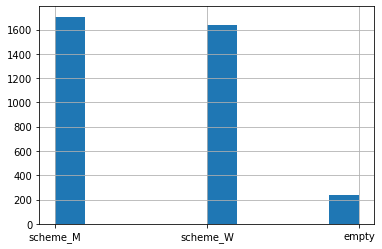

In [ ]:
train_df = pd.DataFrame(list(zip(X_train, y_train)), columns=['Name', 'Class'])
train_df.Class.hist()

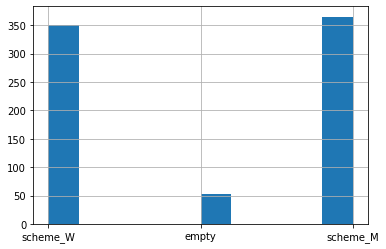

In [ ]:
val_df = pd.DataFrame(list(zip(X_val, y_val)), columns=['Name', 'Class'])
val_df.Class.hist()

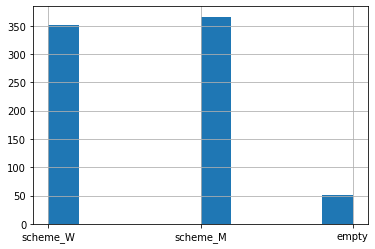

In [ ]:
test_df = pd.DataFrame(list(zip(X_test, y_test)), columns=['Name', 'Class'])
test_df.Class.hist()

In [ ]:
dataset_df = {
    'train' : train_df,
    'val' : val_df,
    'test' : test_df
}

dataset_sizes = {d: len(dataset_df[d]) for d in DATASETS}
print(dataset_sizes)

{'train': 3586, 'val': 768, 'test': 769}


# Transformations

In [ ]:
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

transforms = {'train': T.Compose([
  # Paste this
  T.ToPILImage(),
  
  # T.CenterCrop(size=(400, 500)), # try this

  T.Resize(size=224),
  T.CenterCrop(size=224),

  # Instead of this
  # T.RandomResizedCrop(size=256),
  # T.RandomRotation(degrees=15),
  # T.RandomHorizontalFlip(),

  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]), 'val': T.Compose([                      
  T.ToPILImage(),

  # T.CenterCrop(size=(400, 500)), # try this

  T.Resize(size=224),
  T.CenterCrop(size=224),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]), 'test': T.Compose([
  T.ToPILImage(),

  # T.CenterCrop(size=(400, 500)),  # try this

  T.Resize(size=224),
  T.CenterCrop(size=224),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]),
}

# Dataloader

In [ ]:
dummy_dataset = dataset.BagsDataset(dataset_df['train'], images_path, classes=CLASSES, 
                    transform=transforms['train'])

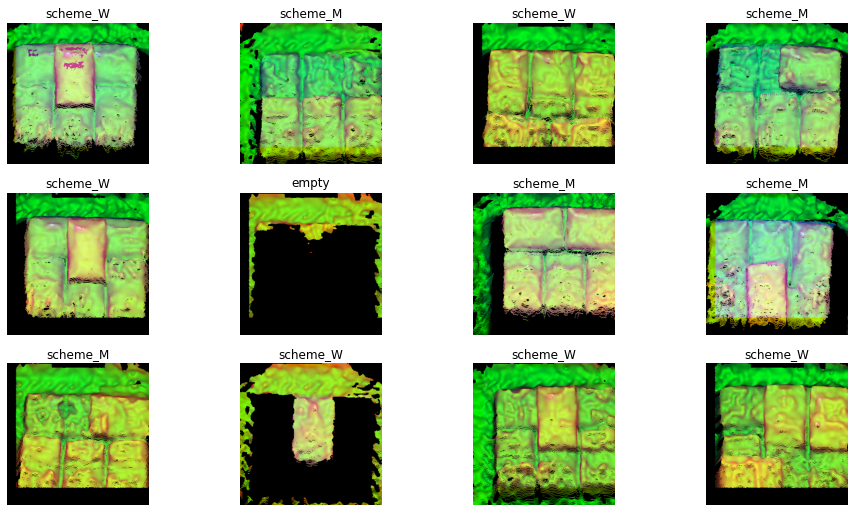

In [ ]:
dummy_dataset.show_batch(n_images=12, figsize=(16, 12))

In [ ]:
data_loaders = {
    d : DataLoader(dataset.BagsDataset(dataset_df[d], images_path, classes=CLASSES, 
                    transform=transforms[d]), batch_size=4, shuffle=True, 
                    num_workers=4) for d in DATASETS
}

# Model

In [ ]:
base_model = model.create_resnet50_model(len(CLASSES), pretrained=True)
base_model.to(device);

# Training

In [ ]:
base_model, history = train.train_model(base_model, data_loaders, dataset_sizes, device, n_epochs=5)

Epoch 1/5
----------
Train loss 0.2630337518895535 accuracy 0.8976575571667597
Val   loss 0.017648859200510476 accuracy 0.9921875

Epoch 2/5
----------
Train loss 0.029880353799386344 accuracy 0.9924707194645845
Val   loss 0.001874596841010619 accuracy 1.0

Epoch 3/5
----------
Train loss 0.00929854324119557 accuracy 0.9983268265476855
Val   loss 0.0004672877420830446 accuracy 1.0

Epoch 4/5
----------
Train loss 0.005394577313859448 accuracy 0.9994422755158952
Val   loss 0.005372949729974152 accuracy 0.9973958333333333

Epoch 5/5
----------
Train loss 0.0017071405607996608 accuracy 1.0
Val   loss 0.003248478646777168 accuracy 0.9986979166666666

Best val accuracy: 1.0


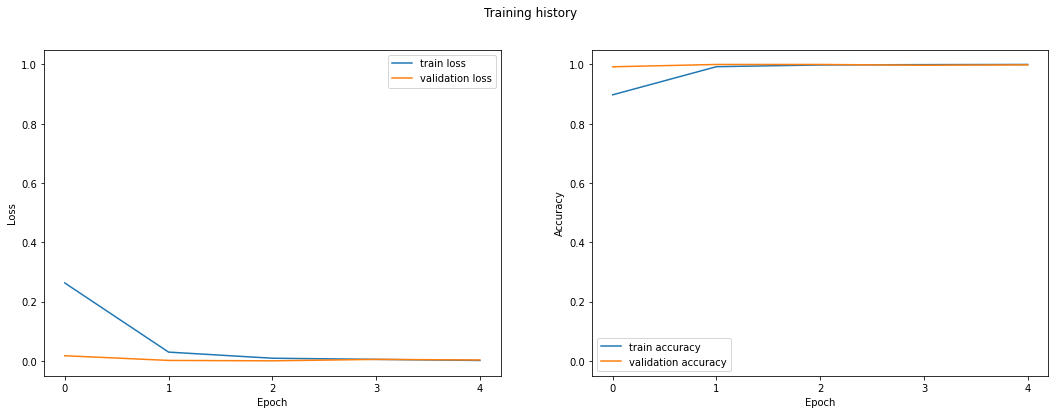

In [ ]:
train.plot_training_history(history)

# Prediction

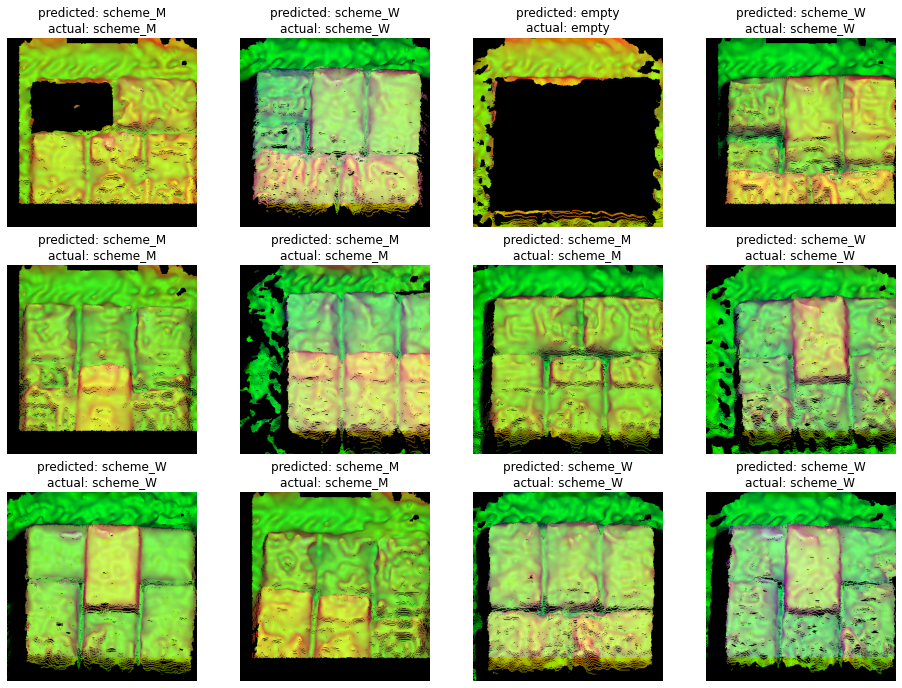

In [ ]:
dummy_dataset.show_predictions(base_model, device, n_images=12, figsize=(16, 16))

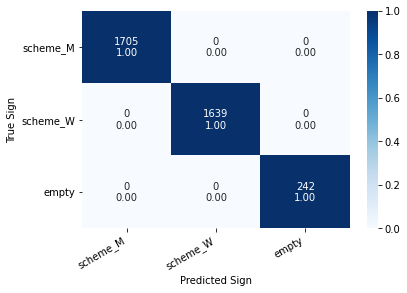

In [ ]:
predict.predict_dataloader(base_model, device, data_loaders['train'], CLASSES, conf_matrix=True);